Welcome to the Disease Prediction and Severity Analysis System


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.1646 - loss: 5.0160 - val_accuracy: 0.2285 - val_loss: 3.6822
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2456 - loss: 3.6507 - val_accuracy: 0.2572 - val_loss: 3.5539
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2592 - loss: 3.5245 - val_accuracy: 0.2640 - val_loss: 3.5182
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2607 - loss: 3.5195 - val_accuracy: 0.2663 - val_loss: 3.4983
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2663 - loss: 3.4401 - val_accuracy: 0.2690 - val_loss: 3.4852
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2607 - loss: 3.4784 - val_accuracy: 0.2681 - val_loss: 3.4757
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2632 - loss: 3.4603 - val_accuracy: 0.2709 - val_loss: 3.4723
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2716 - loss: 3.4558 - val_accuracy: 

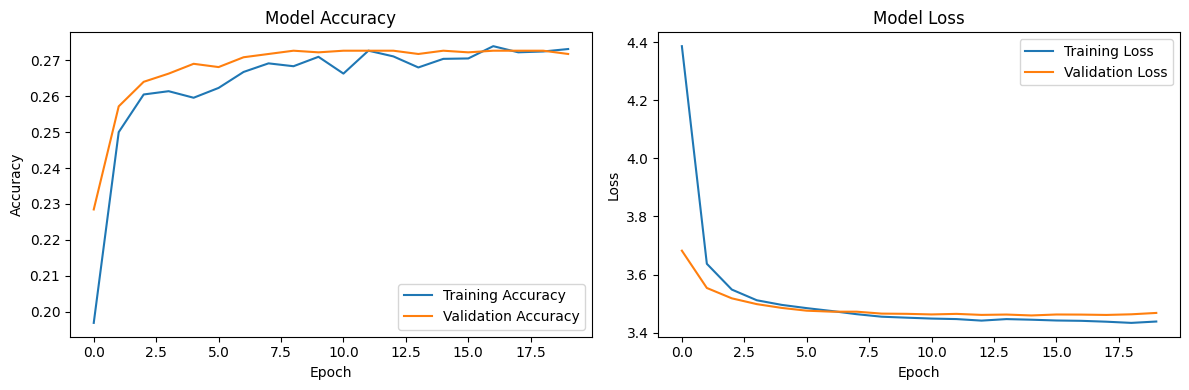

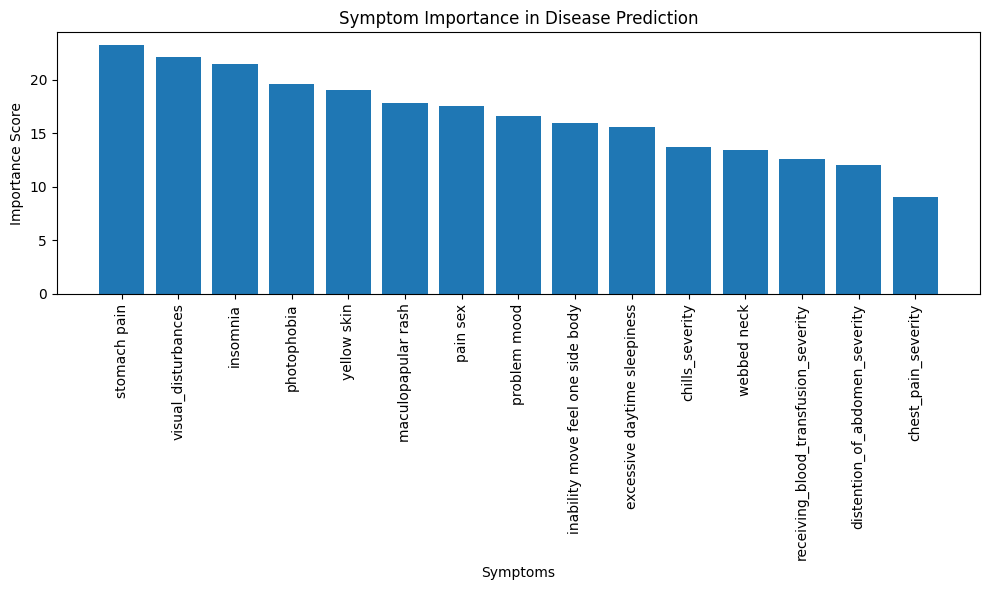


Please provide your symptoms based on the following questions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Based on the symptoms provided:
Predicted Disease: Zika virus disease
Severity Level: Mild

Please consult with a healthcare professional for accurate diagnosis and treatment.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the specific symptoms
SYMPTOMS = [
    'maculopapular rash', 'chest_pain_severity', 'photophobia', 'pain sex',
    'yellow skin', 'stomach pain', 'distention_of_abdomen_severity', 'insomnia',
    'chills_severity', 'inability move feel one side body', 'visual_disturbances',
    'receiving_blood_transfusion_severity', 'excessive daytime sleepiness',
    'problem mood', 'webbed neck'
]

def load_data(file_path):
    return pd.read_csv(file_path)

def preprocess_data(data):
    X = data[SYMPTOMS]
    y = data['Disease']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_one_hot = keras.utils.to_categorical(y_encoded)

    return X, y_one_hot, label_encoder

def build_model(input_dim, output_dim):
    model = keras.Sequential([
        keras.layers.Dense(64, input_dim=input_dim, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_model(X, y, epochs=50, batch_size=32):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(X.shape[1], y.shape[1])
    early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation accuracy: {accuracy:.2f}")

    return model, history

def predict_disease(model, symptoms_input, label_encoder):
    symptoms_array = np.array(symptoms_input).reshape(1, -1)
    prediction = model.predict(symptoms_array)
    disease_idx = np.argmax(prediction)
    return label_encoder.inverse_transform([disease_idx])[0]

def calculate_severity(symptoms_input, symptom_weights):
    severity_score = np.dot(symptoms_input, list(symptom_weights.values()))
    max_possible_score = sum(symptom_weights.values()) * 5  # Assuming max severity of 5 for each symptom
    severity_percentage = (severity_score / max_possible_score) * 100

    if severity_percentage <= 33:
        return "Mild"
    elif severity_percentage <= 66:
        return "Moderate"
    else:
        return "Severe"

def get_user_input():
    symptoms_input = []
    print("\nPlease provide your symptoms based on the following questions:")

    for symptom in SYMPTOMS:
        while True:
            if symptom.endswith('_severity'):
                response = input(f"On a scale of 0-5, how severe is your {symptom.replace('_', ' ')}? ")
                if response.isdigit() and 0 <= int(response) <= 5:
                    symptoms_input.append(int(response))
                    break
                else:
                    print("Invalid input. Please enter a number between 0 and 5.")
            else:
                response = input(f"Do you have {symptom.replace('_', ' ')}? (1 for Yes, 0 for No): ")
                if response in ['0', '1']:
                    symptoms_input.append(int(response))
                    break
                else:
                    print("Invalid input. Please enter 0 for No or 1 for Yes.")

    return symptoms_input

def analyze_feature_importance(model, symptom_names):
    feature_importance = model.layers[0].get_weights()[0]
    importance_scores = np.sum(np.abs(feature_importance), axis=1)
    importance_df = pd.DataFrame({'Symptom': symptom_names, 'Importance': importance_scores})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Symptom'], importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Symptoms')
    plt.ylabel('Importance Score')
    plt.title('Symptom Importance in Disease Prediction')
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    print("Welcome to the Disease Prediction and Severity Analysis System")

    try:
        # Load and preprocess data
        file_path = '/content/reduced_symptoms_dataset.csv'  # Update this path if your file is located elsewhere
        data = load_data(file_path)
        X, y, label_encoder = preprocess_data(data)

        # Train model
        model, history = train_model(X, y)

        # Plot training history
        plot_training_history(history)

        # Analyze feature importance
        analyze_feature_importance(model, SYMPTOMS)

        # Define symptom weights (adjust based on medical knowledge)
        symptom_weights = {symptom: 1.0 for symptom in SYMPTOMS}

        while True:
            symptoms_input = get_user_input()

            predicted_disease = predict_disease(model, symptoms_input, label_encoder)
            severity = calculate_severity(symptoms_input, symptom_weights)

            print(f"\nBased on the symptoms provided:")
            print(f"Predicted Disease: {predicted_disease}")
            print(f"Severity Level: {severity}")
            print("\nPlease consult with a healthcare professional for accurate diagnosis and treatment.")

            if input("\nWould you like to make another prediction? (y/n): ").lower() != 'y':
                break

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your input data and try again.")

if __name__ == '__main__':
    main()